In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from nerf_model import TinyNerfModel
from nerf_dataset import TinyCybertruckDataset, TinyLegoDataset
from nerf_functions import get_rays, render_rays

In [2]:
# Setting seed because model is sensitive to initialization
seed = 5
torch.manual_seed(seed)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available(): 
    # device = torch.device("mps")
    # CPU might be faster for some Mac users
    device = torch.device("cpu")
    print("Using device: Apple Silicon GPU")
else:
    device = torch.device('cpu')
    print("Using device: CPU")

Using device: NVIDIA GeForce RTX 4080 SUPER


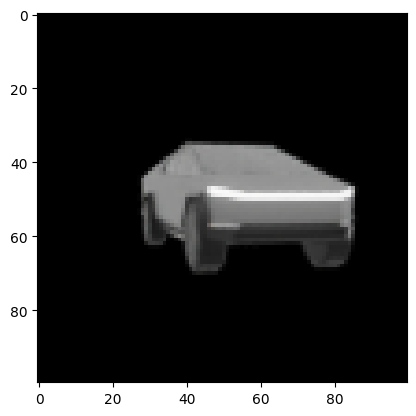

In [4]:
train_data = TinyCybertruckDataset()
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)

testimg, testpose, testfocal = TinyCybertruckDataset(split='test')[0]
testpose = testpose.to(device)

plt.imshow(testimg)
plt.show()

In [5]:
model = TinyNerfModel()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
loss_fn = torch.nn.MSELoss()

In [6]:
# Using Xavier initialization because model performs better (found out through trial and error)
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_
for m in model.modules():
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)

In [7]:
model = model.to(device)

Epoch 0


100%|██████████| 105/105 [00:13<00:00,  7.82it/s]


Epoch took 13.426018714904785 seconds, Loss: 0.005487315822392702


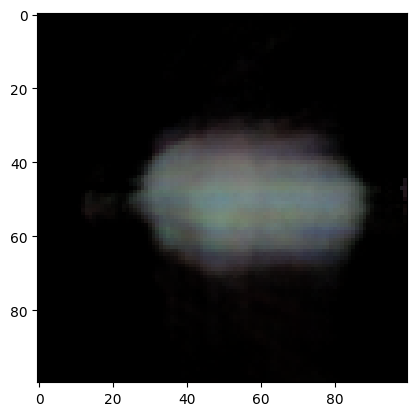

Epoch 1


100%|██████████| 105/105 [00:13<00:00,  8.02it/s]


Epoch took 13.08735966682434 seconds, Loss: 0.0036541824229061604


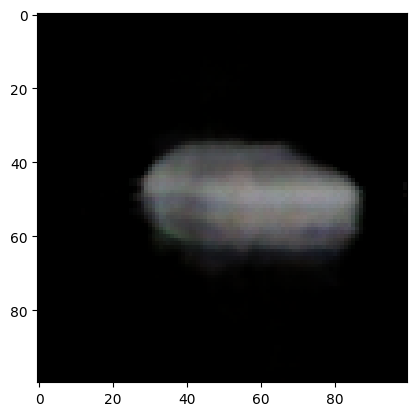

Epoch 2


100%|██████████| 105/105 [00:13<00:00,  8.01it/s]


Epoch took 13.102811813354492 seconds, Loss: 0.0038327372167259455


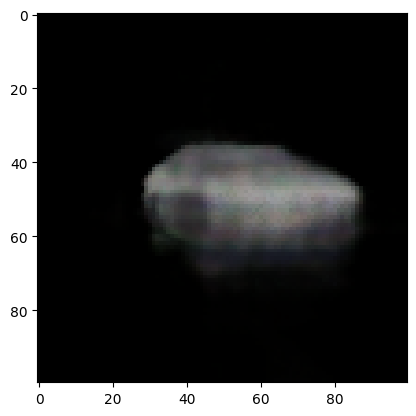

Epoch 3


100%|██████████| 105/105 [00:13<00:00,  8.02it/s]


Epoch took 13.09415078163147 seconds, Loss: 0.004841896705329418


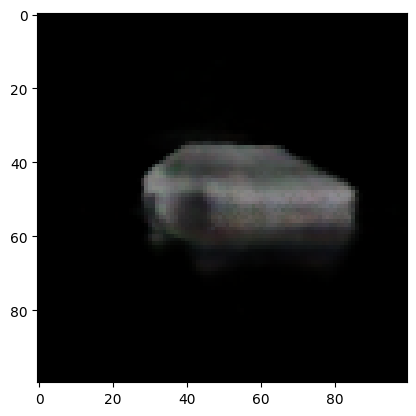

Epoch 4


100%|██████████| 105/105 [00:13<00:00,  8.02it/s]


Epoch took 13.086203575134277 seconds, Loss: 0.0033164802007377148


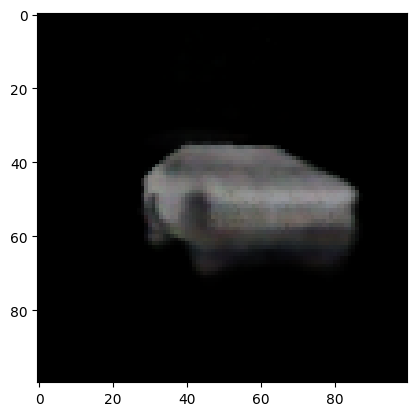

Epoch 5


100%|██████████| 105/105 [00:13<00:00,  8.02it/s]


Epoch took 13.09909701347351 seconds, Loss: 0.0030231024138629436


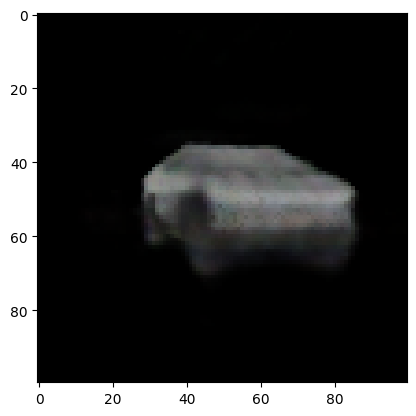

Epoch 6


100%|██████████| 105/105 [00:13<00:00,  8.01it/s]


Epoch took 13.107962369918823 seconds, Loss: 0.0021489369682967663


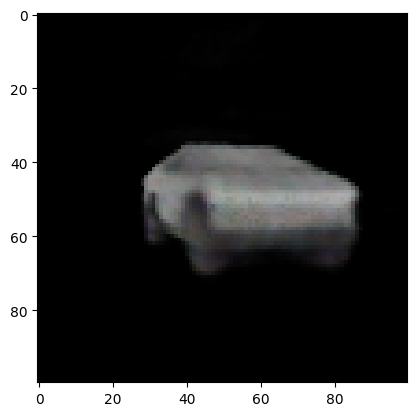

Epoch 7


100%|██████████| 105/105 [00:13<00:00,  8.00it/s]


Epoch took 13.125433444976807 seconds, Loss: 0.0011636771960183978


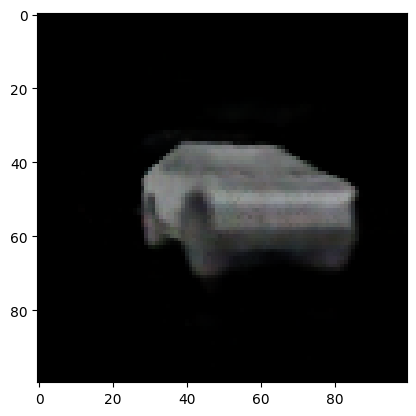

Epoch 8


100%|██████████| 105/105 [00:13<00:00,  8.00it/s]


Epoch took 13.133867025375366 seconds, Loss: 0.0019586989656090736


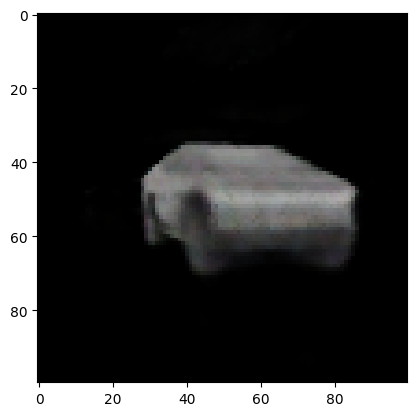

Epoch 9


100%|██████████| 105/105 [00:13<00:00,  8.00it/s]


Epoch took 13.120900630950928 seconds, Loss: 0.0015637142350897193


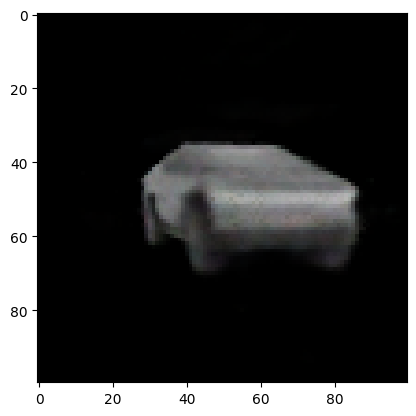

In [8]:
NUM_EPOCHS = 10
near, far = train_data.get_near_far()
H, W = train_data.get_image_size()
N_samples = 64


for i in range(NUM_EPOCHS):
    print(f"Epoch {i}")
    start_time = time.time()
    
    for target_image, pose, focal in tqdm(train_dataloader):
        target_image = target_image.to(device)
        pose = pose.squeeze().to(device)
        focal = focal.to(device)

        rays_o, rays_d = get_rays(H, W, focal, pose, device=device)
        rgb_map = render_rays(model, rays_o, rays_d, near, far, N_samples, device=device)
        
        loss = loss_fn(rgb_map, target_image.squeeze())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch took {time.time() - start_time} seconds, Loss: {loss.item()}")
    with torch.no_grad():
        rays_o, rays_d = get_rays(H, W, testfocal, testpose, device=device)
        rgb = render_rays(model, rays_o, rays_d, near, far, N_samples, device=device)
        plt.imshow(rgb.cpu().numpy())
        plt.show()

